This note book plots a filtered spectrogram of a siren recording using a filter layer with trainable parameters.

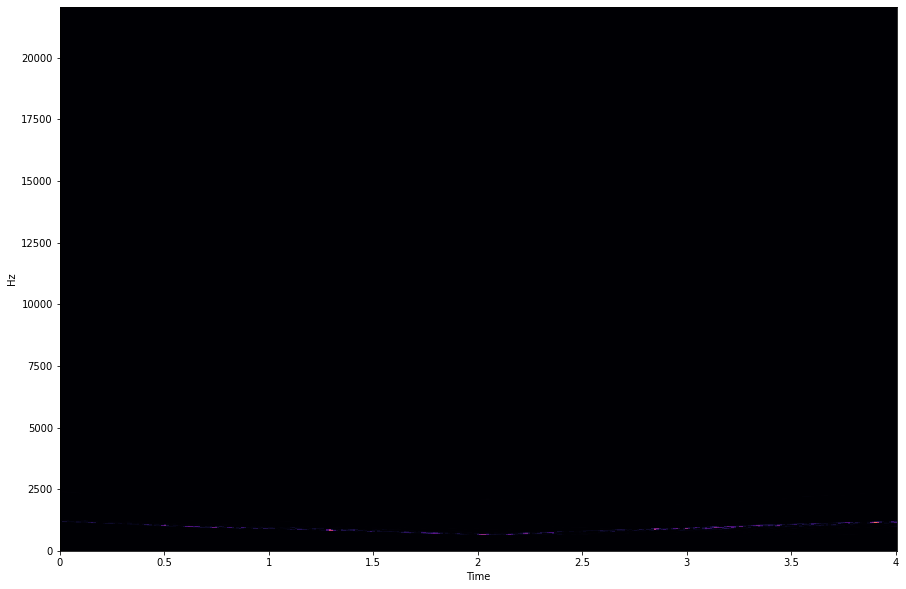

In [67]:
import torch
import torchaudio
from IPython.display import Audio
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# if using google colab this should be the path to the wav file included in the github
siren_wav_file = "/content/74726-8-0-15.wav"

siren, sr = torchaudio.load(siren_wav_file)
siren = siren[:1][:] # one channel sound

# create and plot a spectrogram for the wav file
# this is not log scaled amplitude, so the shape of the siren signal is not very clear

spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=2048,
    win_length=None,
    hop_length=512,
    power=2.0,
)

siren_spec = spectrogram(siren)

plt.figure(figsize=(15, 10))
librosa.display.specshow(siren_spec.numpy()[0], 
    sr=sr, 
    hop_length=512, 
    x_axis="time", 
    y_axis="linear")
plt.show()

In [28]:
# changes the amplitudes to zero mean normal distribution, which is useful for cross entropy loss
def normalize(input):
    return (input - input.mean())/input.std()

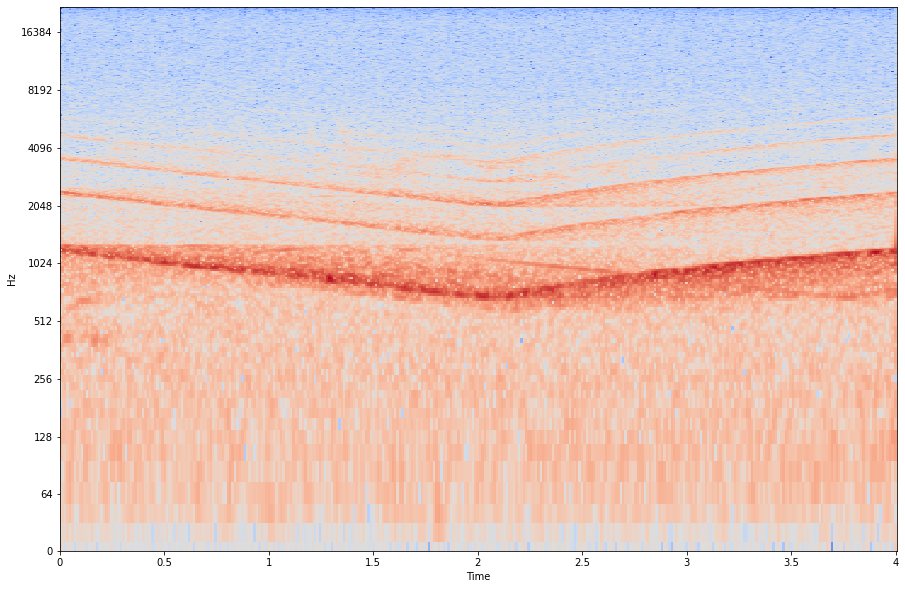

In [37]:
# plots log scaled amplitude spectrogram normalized to zero mean
# this shows the shape of the siren signal but has lots of noise

to_DB = torchaudio.transforms.AmplitudeToDB()
norm_siren_spec = normalize(to_DB(siren_spec))

plt.figure(figsize=(15, 10))
librosa.display.specshow(norm_siren_spec.numpy()[0], 
    sr=sr, 
    hop_length=512, 
    x_axis="time", 
    y_axis="log")
plt.show()

In [48]:
# the filter layer for my convulutional network which has parameters that can be trained

from torch import nn

class myFilter(nn.Module):
    def __init__(self, sampling_rate = 22050):
        super().__init__()
        self.sampling_rate = sampling_rate
        amplitude_scale = torch.Tensor(1,device = 'cpu')
        self.amplitude_scale = nn.Parameter(amplitude_scale)
        central_freq = torch.Tensor(1,device = 'cpu')
        self.central_freq = nn.Parameter(central_freq)
        
    def forward(self, filter_parameters: torch.Tensor, input: torch.Tensor):
        # assign filter parameters 
        self.amplitude_scale = nn.Parameter(filter_parameters[0][0])
        self.central_freq = nn.Parameter(filter_parameters[0][1])

        # apply filters to the signal
        filtered_signal = input/self.amplitude_scale
        filtered_signal = torchaudio.functional.bandpass_biquad(
            waveform = input, 
            sample_rate = self.sampling_rate, 
            central_freq = self.central_freq,
            Q = 0.001)
        return filtered_signal

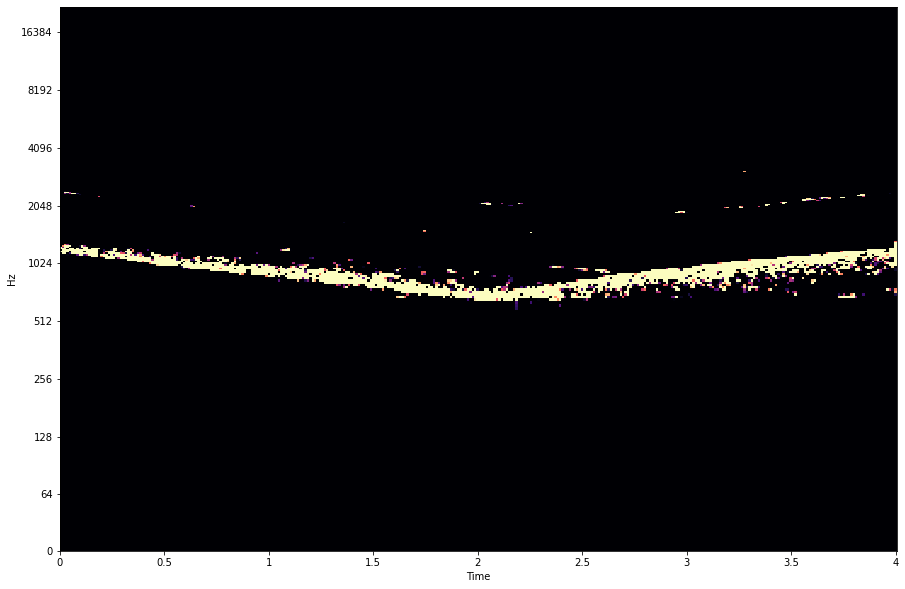

In [68]:
# plots an example result for the filter applied to a spectrogram
# the noise from the signal is mostly gone in this example, so just the fundamental frequencies of the siren tone is included

filter_params = torch.Tensor(1,device = 'cpu')

filt1 = myFilter()

plt.figure(figsize=(15, 10))

librosa.display.specshow(filt1(torch.Tensor([[5, 1000]]), to_DB(siren_spec)).detach().numpy()[0], 
    sr=sr, 
    hop_length=512, 
    x_axis="time", 
    y_axis="log")
plt.show()